In [3]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae1 import *
from KDEs import *
from toolbox import *
import warnings
import itertools
import os

warnings.filterwarnings("ignore")

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)

u = ecdf_brr(data.return_brr)
v = ecdf_btc(data.return_btc)

brr = np.array(data.return_brr)
btc = np.array(data.return_btc)

kde_brr = KDE(data.return_brr, "Gaussian")
kde_btc = KDE(data.return_btc, "Gaussian")

kde_brr = KDE(data.return_brr, "Gaussian", kde_brr.h_brot*3)
kde_btc = KDE(data.return_brr, "Gaussian", kde_btc.h_brot*3)

In [4]:
# Gaussian, t_Copula, Clayton, Frank, Gumbel, Plackett, Gaussian mix Indep
C1  = Gaussian(dict(rho=0.9),       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
C2  = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=2) 
C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=4) 
C3  = Clayton(dict(theta=0.1),      Law_RS=kde_brr, Law_RF=kde_btc)
C4  = Frank(dict(theta=0.1),        Law_RS=kde_brr, Law_RF=kde_btc)
C5  = Gumbel(dict(theta=3),         Law_RS=kde_brr, Law_RF=kde_btc)
C6  = Plackett(dict(theta=10),      Law_RS=kde_brr, Law_RF=kde_btc)
C7  = Gaussian_Mix_Independent(dict(rho=.9,p=0.7),Law_RS=kde_brr, Law_RF=kde_btc)
Copulae_names = ['Gaussian', 't_Copula', 't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr   = [C1,C2,C2c,C3,C4,C5,C6,C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))

In [ ]:
results = []
ls = os.listdir('../processed_data/crix_brr/train/')
ls = [l for l in ls if l.endswith('.csv')]
for file in ls:
    print(file)
    train = pd.read_csv('../processed_data/crix_brr/train/'+file)
    btc = train.loc[:,'log return crix'].iloc[:-1]
    brr = train.loc[:,'log return brr'].iloc[1:]
    u = ECDF(brr)(brr)
    v = ECDF(btc)(btc)
    plt.scatter(u,v)
    paras = []
    likelihood = []
    for C_name in Copulae:
        Copulae[C_name].canonical_calibrate(u,v)
        print(C_name,'is done.\n')
    
    for C_name in Copulae:
        paras.append((C_name,Copulae[C_name].paras))
        
    for C_name in Copulae:
        ln = Copulae[C_name].dependency_likelihood(u,v)
        likelihood.append((C_name,ln))
        
    results.append([paras, likelihood])

6.csv
Optimization terminated successfully.
         Current function value: -0.205614
         Iterations: 34
         Function evaluations: 73
Gaussian is done.



In [22]:
c_arr = []
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv('../processed_data/crix_brr/train/'+file)
    a = pd.DataFrame(results[i][0])
    a.columns = ['Copula_name', 'paras']
    a.index = a.iloc[:,0]
    b = pd.DataFrame(results[i][1])
    b.index = b.iloc[:,0]
    c = pd.concat([a.iloc[:,1],b.iloc[:,1]],axis=1)
    c.columns = ['paras', 'likelihood']
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)
    print(date_range)
    c_arr.append(c)

2019-08-01 to 2020-07-31
2019-07-01 to 2020-06-30
2019-09-01 to 2020-08-31
2019-10-01 to 2020-09-30
2020-02-01 to 2021-01-31
2020-01-01 to 2020-12-31
2019-11-01 to 2020-10-31
2019-12-01 to 2020-11-30
2018-03-01 to 2019-02-28
2018-04-01 to 2019-03-31
2018-06-01 to 2019-05-31
2018-05-01 to 2019-04-30
2018-07-01 to 2019-06-30
2018-08-01 to 2019-07-31
2018-10-01 to 2019-09-30
2018-09-01 to 2019-08-31
2018-11-01 to 2019-10-31
2018-12-01 to 2019-11-30
2019-04-01 to 2020-03-31
2019-03-01 to 2020-02-29
2019-01-01 to 2019-12-31
2019-02-01 to 2020-01-31
2019-05-01 to 2020-04-30
2019-06-01 to 2020-05-31


In [23]:
result = pd.concat(dict(zip(date_range_arr, c_arr)), axis=1)

In [24]:
result.iloc[:,[i for i in range(len(result.columns)) if i%2!=0]].style.highlight_max(color = 'lightgreen', axis = 0)

,2018-03-01 to 2019-02-28,2018-04-01 to 2019-03-31,2018-05-01 to 2019-04-30,2018-06-01 to 2019-05-31,2018-07-01 to 2019-06-30,2018-08-01 to 2019-07-31,2018-09-01 to 2019-08-31,2018-10-01 to 2019-09-30,2018-11-01 to 2019-10-31,2018-12-01 to 2019-11-30,2019-01-01 to 2019-12-31,2019-02-01 to 2020-01-31,2019-03-01 to 2020-02-29,2019-04-01 to 2020-03-31,2019-05-01 to 2020-04-30,2019-06-01 to 2020-05-31,2019-07-01 to 2020-06-30,2019-08-01 to 2020-07-31,2019-09-01 to 2020-08-31,2019-10-01 to 2020-09-30,2019-11-01 to 2020-10-31,2019-12-01 to 2020-11-30,2020-01-01 to 2020-12-31,2020-02-01 to 2021-01-31
,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood
Gaussian,0.0940355,0.0821246,0.0983441,0.0825748,0.0664093,0.0784167,0.0689618,0.0771837,0.0828748,0.0653481,0.0672812,0.0652092,0.0709164,0.0815125,0.083532,0.0852396,0.0948459,0.0781666,0.0713773,0.0620098,0.0603311,0.0694053,0.0665555,0.0597621
t_Copula,0.0996315,0.0957628,0.106801,0.104111,0.0930016,0.103992,0.0910209,0.102805,0.115961,0.102588,0.11107,0.105933,0.10741,0.115717,0.112086,0.101368,0.110024,0.102834,0.102258,0.092143,0.0897061,0.0870248,0.0794566,0.0853684
t_Copula_Capped,0.0996315,0.0957628,0.106801,0.10447,0.0931371,0.104256,0.0914384,0.102891,0.113955,0.0995147,0.105307,0.100762,0.103554,0.11258,0.110732,0.101368,0.110024,0.101878,0.100109,0.0901417,0.0881816,0.0870248,0.0794566,0.0853681
Clayton,0.0942136,0.0804416,0.0992882,0.0814575,0.0660239,0.0786345,0.0716465,0.0818418,0.0772486,0.0521769,0.0512476,0.0497623,0.0583403,0.0676445,0.0679317,0.0723449,0.0806745,0.065357,0.0551608,0.046808,0.0533066,0.0620235,0.0594626,0.0418389
Frank,0.0908128,0.0773502,0.0866853,0.0676419,0.0556399,0.0666177,0.0539832,0.0629881,0.0608238,0.044899,0.0442372,0.0412624,0.0447928,0.0542888,0.0555561,0.059447,0.0628885,0.0498753,0.0449085,0.0370874,0.0399838,0.0486851,0.0457005,0.0422805
Gumbel,0.0745673,0.0731481,0.0821212,0.0815007,0.0676066,0.0776708,0.0657377,0.0729065,0.0911749,0.0830505,0.089498,0.0856868,0.0876511,0.0966499,0.0977971,0.0898241,0.100801,0.0907495,0.090696,0.0828271,0.0740305,0.0753827,0.0670298,0.0744402
Plackett,inf,2.77149,2.80428,2.56597,2.50949,inf,2.5723,2.55853,inf,inf,inf,inf,2.57858,2.70692,2.74808,inf,3.06998,2.92079,inf,inf,inf,3.02004,inf,inf
Gauss Mix Indep,0.101792,0.0987414,0.108375,0.106461,0.093858,0.10528,0.0896279,0.102844,0.107758,0.0914638,0.0957552,0.0903756,0.0914262,0.101882,0.0987679,0.0930924,0.10025,0.0917779,0.0892476,0.0795013,0.0813819,0.0807065,0.0750077,0.0785084


In [25]:
result.iloc[:,[i for i in range(len(result.columns)) if i%2==0]]

,2018-03-01 to 2019-02-28,2018-04-01 to 2019-03-31,2018-05-01 to 2019-04-30,2018-06-01 to 2019-05-31,2018-07-01 to 2019-06-30,2018-08-01 to 2019-07-31,2018-09-01 to 2019-08-31,2018-10-01 to 2019-09-30,2018-11-01 to 2019-10-31,2018-12-01 to 2019-11-30,...,2019-05-01 to 2020-04-30,2019-06-01 to 2020-05-31,2019-07-01 to 2020-06-30,2019-08-01 to 2020-07-31,2019-09-01 to 2020-08-31,2019-10-01 to 2020-09-30,2019-11-01 to 2020-10-31,2019-12-01 to 2020-11-30,2020-01-01 to 2020-12-31,2020-02-01 to 2021-01-31
,paras,paras,paras,paras,paras,paras,paras,paras,paras,paras,...,paras,paras,paras,paras,paras,paras,paras,paras,paras,paras
Gaussian,{'rho': 0.4202429199675922},{'rho': 0.3946160666491354},{'rho': 0.4240371267998141},{'rho': 0.3872700222134552},{'rho': 0.34881747365098537},{'rho': 0.3786253178120287},{'rho': 0.3555188429748704},{'rho': 0.3756425551233422},{'rho': 0.3784731999436723},{'rho': 0.33592892801010554},...,{'rho': 0.37992122313020316},{'rho': 0.3837321891999347},{'rho': 0.4043006434688763},{'rho': 0.3676139542087914},{'rho': 0.351219594815297},{'rho': 0.3269808519605811},{'rho': 0.32237073053945225},{'rho': 0.3462194858448032},{'rho': 0.33363034858458357},{'rho': 0.3194971694331832}
t_Copula,"{'rho': 0.42453853175530876, 'nu': 6.616794421...","{'rho': 0.39260600632915976, 'nu': 4.230997372...","{'rho': 0.4167833832905564, 'nu': 4.7305446088...","{'rho': 0.36628144976089977, 'nu': 3.216256094...","{'rho': 0.32971970476484036, 'nu': 2.961859822...","{'rho': 0.3602049890310267, 'nu': 3.0009555912...","{'rho': 0.3213005391446749, 'nu': 3.0786631030...","{'rho': 0.3448744887980223, 'nu': 2.8559996398...","{'rho': 0.34013572703509565, 'nu': 3.040754533...","{'rho': 0.2883389993804061, 'nu': 2.8463036082...",...,"{'rho': 0.3266600358786542, 'nu': 3.1982591588...","{'rho': 0.3537306912170828, 'nu': 4.7764258389...","{'rho': 0.3630635550164039, 'nu': 4.3882218471...","{'rho': 0.3130768862702158, 'nu': 3.3360639670...","{'rho': 0.2932687968054532, 'nu': 2.9990085077...","{'rho': 0.2653211148008746, 'nu': 3.0398695452...","{'rho': 0.2808396560284173, 'nu': 3.1726519811...","{'rho': 0.3201041850580951, 'nu': 4.5751843009...","{'rho': 0.30902874113729, 'nu': 5.119847884628...","{'rho': 0.28230859440889056, 'nu': 3.189699269..."
t_Copula_Capped,"{'rho': 0.4245385244826459, 'nu': 6.6167929936...","{'rho': 0.39260600902119547, 'nu': 4.230997132...","{'rho': 0.4167833768748692, 'nu': 4.7305435973...","{'rho': 0.37807370504917504, 'nu': 4.000000000...","{'rho': 0.3468380713182193, 'nu': 4.0000000000...","{'rho': 0.3772394948899327, 'nu': 4.0000000000...","{'rho': 0.33891105717550507, 'nu': 4.000000000...","{'rho': 0.36747587017120886, 'nu': 4.000000000...","{'rho': 0.3591252670509119, 'nu': 4.0000000000...","{'rho': 0.3134004882515167, 'nu': 4.0000000000...",...,"{'rho': 0.34347844504732006, 'nu': 4.000000000...","{'rho': 0.3537306982215176, 'nu': 4.7764264950...","{'rho': 0.3630635754393078, 'nu': 4.3882224829...","{'rho': 0.3260113068107484, 'nu': 4.0000000000...","{'rho': 0.31481884297464957, 'nu': 4.000000000...","{'rho': 0.285408802678078, 'nu': 4.00000000000...","{'rho': 0.2956378148760438, 'nu': 4.0000000000...","{'rho': 0.3201041911487478, 'nu': 4.5751849567...","{'rho': 0.3090287368119137, 'nu': 5.1198475911...","{'rho': 0.29700601910295915, 'nu': 4.000000000..."
Clayton,{'theta': 0.6378796319053274},{'theta': 0.5793216421444888},{'theta': 0.6609113166240679},{'theta': 0.5794700757575141},{'theta': 0.5177188402374234},{'theta': 0.5758765220269327},{'theta': 0.5387728446872332},{'theta': 0.5899410154331565},{'theta': 0.5657871299505491},{'theta': 0.4499979668847118},...,{'theta': 0.5241628163230051},{'theta': 0.5433749903598372},{'theta': 0.5725259241721268},{'theta': 0.5042982149124161},{'theta': 0.4570518770113451},{'theta': 0.40916003568428827},{'theta': 0.4448167376130304},{'theta': 0.4854945865648239},{'theta': 0.47068125412544226},{'theta': 0.3948041808391526}
Frank,{'theta': 2.7484138376851375},{'theta': 2.5544847516114038},

In [31]:
result.iloc[[0,1,2,3,4,5,7],[i for i in range(len(result.columns)) if i%2!=0]].style.highlight_max(color = 'lightgreen', axis = 0)

,2018-03-01 to 2019-02-28,2018-04-01 to 2019-03-31,2018-05-01 to 2019-04-30,2018-06-01 to 2019-05-31,2018-07-01 to 2019-06-30,2018-08-01 to 2019-07-31,2018-09-01 to 2019-08-31,2018-10-01 to 2019-09-30,2018-11-01 to 2019-10-31,2018-12-01 to 2019-11-30,2019-01-01 to 2019-12-31,2019-02-01 to 2020-01-31,2019-03-01 to 2020-02-29,2019-04-01 to 2020-03-31,2019-05-01 to 2020-04-30,2019-06-01 to 2020-05-31,2019-07-01 to 2020-06-30,2019-08-01 to 2020-07-31,2019-09-01 to 2020-08-31,2019-10-01 to 2020-09-30,2019-11-01 to 2020-10-31,2019-12-01 to 2020-11-30,2020-01-01 to 2020-12-31,2020-02-01 to 2021-01-31
,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood,likelihood
Gaussian,0.0940355,0.0821246,0.0983441,0.0825748,0.0664093,0.0784167,0.0689618,0.0771837,0.0828748,0.0653481,0.0672812,0.0652092,0.0709164,0.0815125,0.083532,0.0852396,0.0948459,0.0781666,0.0713773,0.0620098,0.0603311,0.0694053,0.0665555,0.0597621
t_Copula,0.0996315,0.0957628,0.106801,0.104111,0.0930016,0.103992,0.0910209,0.102805,0.115961,0.102588,0.11107,0.105933,0.10741,0.115717,0.112086,0.101368,0.110024,0.102834,0.102258,0.092143,0.0897061,0.0870248,0.0794566,0.0853684
t_Copula_Capped,0.0996315,0.0957628,0.106801,0.10447,0.0931371,0.104256,0.0914384,0.102891,0.113955,0.0995147,0.105307,0.100762,0.103554,0.11258,0.110732,0.101368,0.110024,0.101878,0.100109,0.0901417,0.0881816,0.0870248,0.0794566,0.0853681
Clayton,0.0942136,0.0804416,0.0992882,0.0814575,0.0660239,0.0786345,0.0716465,0.0818418,0.0772486,0.0521769,0.0512476,0.0497623,0.0583403,0.0676445,0.0679317,0.0723449,0.0806745,0.065357,0.0551608,0.046808,0.0533066,0.0620235,0.0594626,0.0418389
Frank,0.0908128,0.0773502,0.0866853,0.0676419,0.0556399,0.0666177,0.0539832,0.0629881,0.0608238,0.044899,0.0442372,0.0412624,0.0447928,0.0542888,0.0555561,0.059447,0.0628885,0.0498753,0.0449085,0.0370874,0.0399838,0.0486851,0.0457005,0.0422805
Gumbel,0.0745673,0.0731481,0.0821212,0.0815007,0.0676066,0.0776708,0.0657377,0.0729065,0.0911749,0.0830505,0.089498,0.0856868,0.0876511,0.0966499,0.0977971,0.0898241,0.100801,0.0907495,0.090696,0.0828271,0.0740305,0.0753827,0.0670298,0.0744402
Gauss Mix Indep,0.101792,0.0987414,0.108375,0.106461,0.093858,0.10528,0.0896279,0.102844,0.107758,0.0914638,0.0957552,0.0903756,0.0914262,0.101882,0.0987679,0.0930924,0.10025,0.0917779,0.0892476,0.0795013,0.0813819,0.0807065,0.0750077,0.0785084


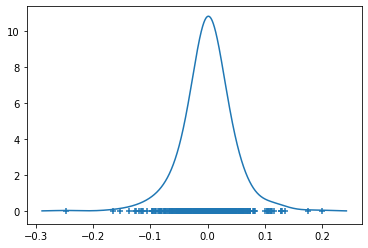

In [11]:
kde_brr = KDE(data.return_brr, "Gaussian")
kde_btc = KDE(data.return_btc, "Gaussian")

kde_brr = KDE(data.return_brr, "Gaussian", kde_brr.h_brot*3)
kde_btc = KDE(data.return_brr, "Gaussian", kde_btc.h_brot*3)
kde_brr.plot_density()

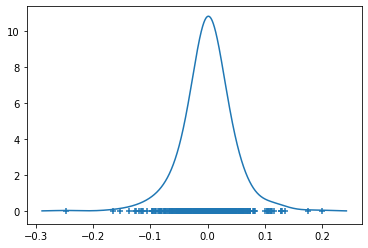

In [12]:
kde_brr.plot_density()

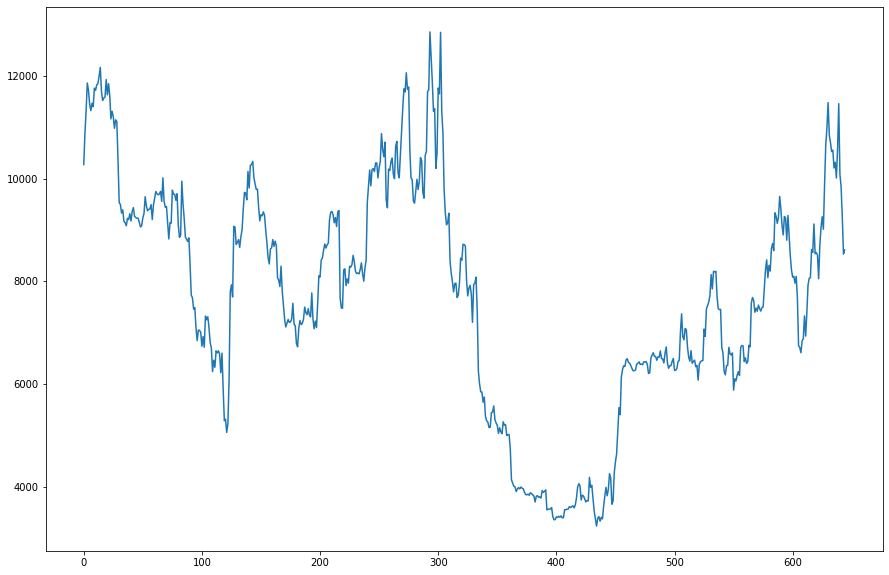

In [13]:
plt.figure(figsize=(15,10))
plt.plot(data.iloc[:,6])

In [14]:
np.argmax(data.return_brr)

216

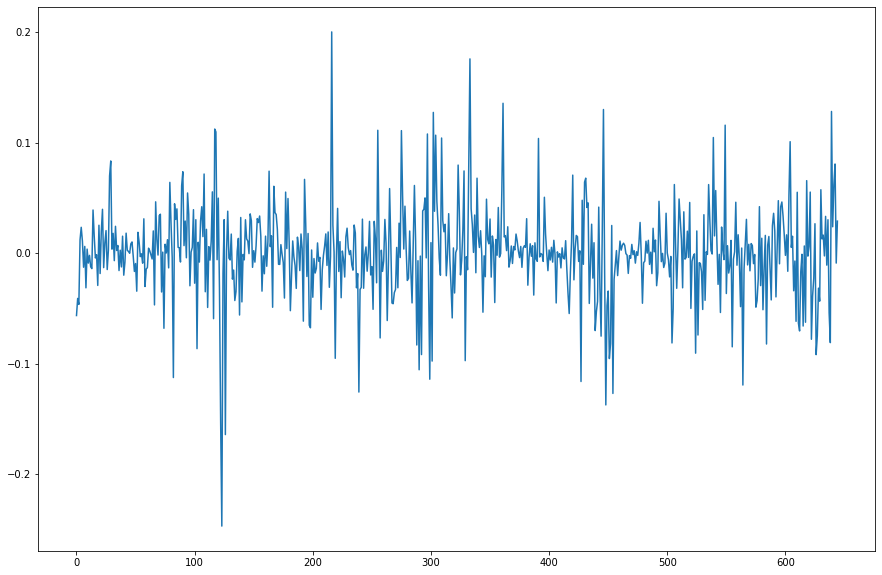

In [15]:
plt.figure(figsize=(15,10))
plt.plot(data.return_brr)

In [16]:
kde_brr.h_brot

0.02197382561545512

Text(0, 0.5, '$R^F$')

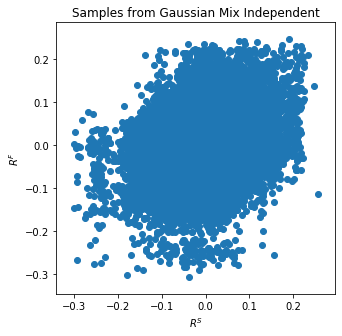

In [17]:
s = Gaussian_Mix_Independent(C7.paras, kde_brr, kde_btc).sample(100000)
plt.figure(figsize=(5,5))
plt.scatter(s[:,0],s[:,1])
plt.title("Samples from Gaussian Mix Independent")
plt.xlabel(r"$R^S$")
plt.ylabel(r"$R^F$")

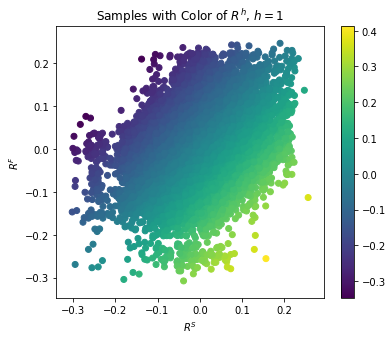

In [18]:
h=1
rh = s[:,0] - h*s[:,1]
plt.figure(figsize=(6,5))
plt.scatter(s[:,0],s[:,1],c=rh)
plt.title(r"Samples with Color of $R^h$, $h=1$")
plt.xlabel(r"$R^S$")
plt.ylabel(r"$R^F$")
plt.colorbar()

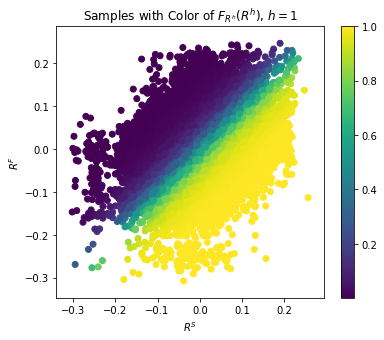

In [19]:
h=1
rh = s[:,0] - h*s[:,1]
plt.figure(figsize=(6,5))
plt.scatter(s[:,0],s[:,1],c=ECDF(rh)(rh))
plt.title(r"Samples with Color of $F_{R^h}(R^h)$, $h=1$")
plt.xlabel(r"$R^S$")
plt.ylabel(r"$R^F$")
plt.colorbar()

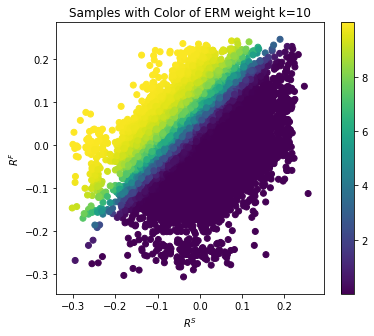

In [20]:
h=1
rh = s[:,0] - h*s[:,1]
plt.figure(figsize=(6,5))
plt.scatter(s[:,0],s[:,1],c=ERM_weight(10,ECDF(rh)(rh)))
plt.title(r"Samples with Color of ERM weight k=10")
plt.xlabel(r"$R^S$")
plt.ylabel(r"$R^F$")
plt.colorbar()

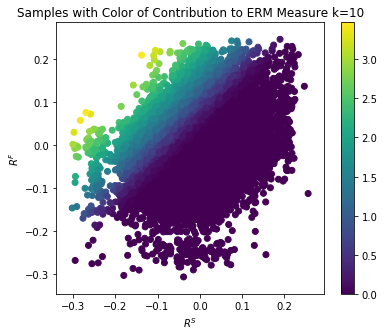

In [21]:
h=1
rh = s[:,0] - h*s[:,1]
plt.figure(figsize=(6,5))
plt.scatter(s[:,0],s[:,1],c=-ERM_weight(10,ECDF(rh)(rh))*rh)
plt.title(r"Samples with Color of Contribution to ERM Measure k=10")
plt.xlabel(r"$R^S$")
plt.ylabel(r"$R^F$")
plt.colorbar()